<a href="https://colab.research.google.com/github/vikasmeena23/DMS672-Assignments-/blob/main/Titanic_data_FamilySize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Important libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Age formatting and FamilySize column

In [ ]:
df = pd.read_csv("titanic_train.csv")
df["FamilySize"] = df["Parch"] + df["SibSp"] + 1
# Round the values in the "Age" column and convert to int32
df["Age"] = df["Age"].round().astype("Int32")
df.loc[df["Age"] == 0, "Age"] = 1
df["Age"].count()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    Int32  
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  FamilySize   891 non-null    int64  
dtypes: Int32(1), float64(1), int64(6), object(5)
memory usage: 88.0+ KB
None


##  Checking if all the family members have same ticket

In [ ]:
print(df["FamilySize"].value_counts())

FamilySize
1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: count, dtype: int64


In [ ]:
# Step 1: Get frequency of each ticket value
ticket_freq = df['Ticket'].value_counts()

# Step 2: Count how many tickets occur with frequency 1, 2, 3, ...
frequency_of_frequencies = ticket_freq.value_counts().sort_index()

# Display the result
print(frequency_of_frequencies)


count
1    547
2     94
3     21
4     11
5      2
6      3
7      3
Name: count, dtype: int64


There are two possibilities:
*  Family members are travelling on different ticket.
*  Those travelling on same ticket may not be family members, they may be neighbours or friends.

Hence we will do our analysis based on these two types of people to understand the relation between survival and having same ticket and survival and family size.

## Introducing Surname column to identify members from same family and FamilyID to consider those from same family but not having same ticket

In [ ]:
# Extract surname from Name
df['Surname'] = df['Name'].apply(lambda x: x.split(',')[0].strip())
df['Surname'].count()

np.int64(891)

In [ ]:
# Create a Family ID using Surname + Ticket (better than FamilySize alone)
df['FamilyID'] = df['Surname'] + '_' + df['Ticket']
df['FamilyID'].head()

,FamilyID
0,Braund_A/5 21171
1,Cumings_PC 17599
2,Heikkinen_STON/O2. 3101282
3,Futrelle_113803
4,Allen_373450


## Plotting the survival rate based on the Family Size.

In [ ]:
# Group by FamilyID and compute survival rate and family size
family_stats = df.groupby('FamilyID').agg(
    FamilySize=('FamilySize', 'first'),  # All members have same size
    TotalMembers=('Survived', 'count'),
    SurvivedMembers=('Survived', 'sum')
).reset_index()

# Add survival rate
family_stats['SurvivalRate'] = family_stats['SurvivedMembers'] / family_stats['TotalMembers']

# Add Surname
family_stats['Surname'] = family_stats['FamilyID'].apply(lambda x: x.split('_')[0])


In [ ]:
family_stats.head()

,FamilyID,FamilySize,TotalMembers,SurvivedMembers,SurvivalRate,Surname
0,Abbing_C.A. 5547,1,1,0,0.0,Abbing
1,Abbott_C.A. 2673,3,2,1,0.5,Abbott
2,Abelson_P/PP 3381,2,2,1,0.5,Abelson
3,Adahl_C 7076,1,1,0,0.0,Adahl
4,Adams_341826,1,1,0,0.0,Adams


In [ ]:
# Group families by family size and compute average survival rate
fs_survival = family_stats.groupby('FamilySize')['SurvivalRate'].mean().reset_index()
print(fs_survival)


   FamilySize  SurvivalRate
0           1      0.303738
1           2      0.543417
2           3      0.575000
3           4      0.606061
4           5      0.400000
5           6      0.125000
6           7      0.583333
7           8      0.000000
8          11      0.000000


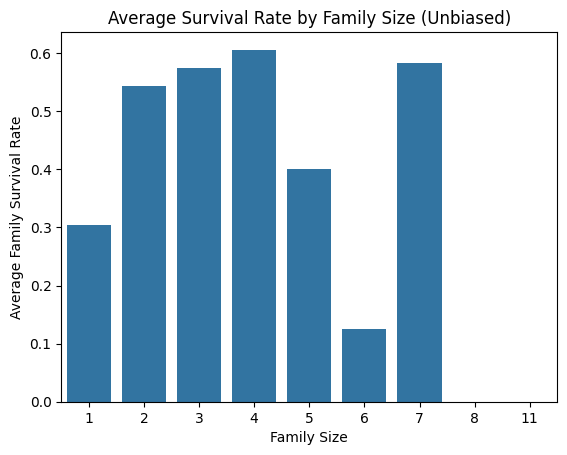

In [ ]:
sns.barplot(data=fs_survival, x='FamilySize', y='SurvivalRate')
plt.title('Average Survival Rate by Family Size (Unbiased)')
plt.xlabel('Family Size')
plt.ylabel('Average Family Survival Rate')
plt.show()


This shows that families with 2, 3, 4 members have descent chances of survival that is around 55%.  
We have ignored the survival rate of 7 family size since its data size is too less to be considered.

## Plotting survivale rate based on people per ticket

In [ ]:
ticket_stats = df.groupby('Ticket').agg(
    TotalPeople=('Survived', 'count'),
    SurvivedPeople=('Survived', 'sum')
).reset_index()

# Add survival rate
ticket_stats['SurvivalRate'] = ticket_stats['SurvivedPeople'] / ticket_stats['TotalPeople']
ticket_stats

,Ticket,TotalPeople,SurvivedPeople,SurvivalRate
0,110152,3,3,1.000000
1,110413,3,2,0.666667
2,110465,2,0,0.000000
3,110564,1,1,1.000000
4,110813,1,1,1.000000
...,...,...,...,...
676,W./C. 6608,4,0,0.000000
677,W./C. 6609,1,0,0.000000
678,W.E.P. 5734,1,0,0.000000
679,W/C 14208,1,0,0.000000


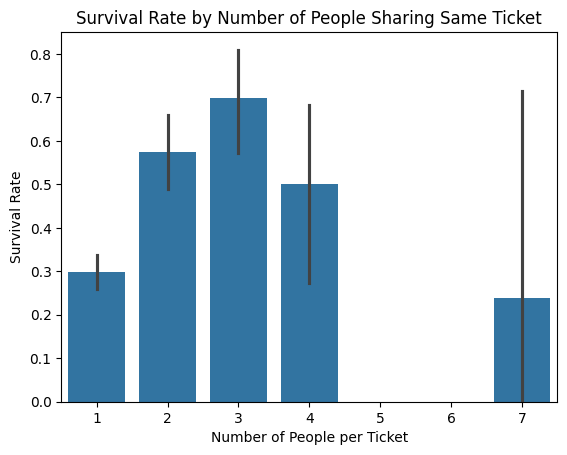

In [ ]:

sns.barplot(data=ticket_stats, x='TotalPeople', y='SurvivalRate')
plt.title('Survival Rate by Number of People Sharing Same Ticket')
plt.xlabel('Number of People per Ticket')
plt.ylabel('Survival Rate')
plt.show()


This shows that 3 people with same ticket have the highest chance of survival, while those with more than 4 on the same ticket have very less chance of survival.